In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
from keras.metrics import accuracy, Recall, AUC
from keras.utils import to_categorical
from keras.activations import relu, sigmoid, softmax
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras import optimizers
from keras.optimizers import Adam,Adagrad
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#from keras.layers import DepthwiseConv2D
from sklearn.neighbors import NearestNeighbors

In [2]:
train = pd.read_csv('finalcls2.csv')
print(train.head())


import keras.utils as image
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('train/'+train['filename'][i],target_size=(600,600,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)


train.drop('filename',axis=1,inplace=True)
y = np.array(train.drop(['status'],axis=1))
y = pd.DataFrame(y,columns = ['overripe','ripe','unripe'])


                                            filename  overripe  ripe  unripe  \
0  okra-27-_jpg.rf.d0e04d2b9f92f4b19cfa009f7a9198...         0     1       0   
1  WhatsApp-Image-2023-01-20-at-08-23-47_jpeg_jpg...         0     1       0   
2  IMG_20220924_131236_1_jpg.rf.ccfe3518664552c4a...         0     1       0   
3  a7e801dbdb129d34967dab39543a0084_jpg.rf.d5726d...         0     1       0   
4  ab7fbd7d4bde6ac573bb1309715b136d_jpg.rf.ccac3c...         1     0       0   

     status  
0      ripe  
1      ripe  
2      ripe  
3      ripe  
4  overripe  


100%|███████████████████████████████████████████████████████████████████████████████| 310/310 [00:02<00:00, 146.99it/s]


In [3]:
reshaped_arr = X.reshape(310, -1)  # reshape to 2D array
feature_names = [f'feature_{i}' for i in range(reshaped_arr.shape[1])]  # create feature names
X = pd.DataFrame(data=reshaped_arr, columns=feature_names)  # create DataFrame

In [4]:
#MLSMOTE
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X,y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=2,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if 'overripe' in nn_df.columns and nn_df['overripe'].sum() > 0 else 0, 
                      1 if 'ripe' in nn_df.columns and nn_df['ripe'].sum() > 0 else 0, 
                      1 if 'unripe' in nn_df.columns and nn_df['unripe'].sum() > 0 else 0])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target


In [5]:
eX,eY = get_minority_instace(X,y)
Xn,Yn = MLSMOTE(eX,eY,200)

y.astype(int)
Yn.astype(int)
fY = pd.concat([y,Yn],axis=0)
fX = pd.concat([X,Xn],axis=0)



def get_label(row):
    if row['overripe'] == 1 and row['ripe'] == 1 and row['unripe'] == 1:
        return 'unripe overripe'
    elif row['overripe'] == 1 and row['ripe'] == 1:
        return 'overripe ripe'
    elif row['unripe'] == 1 and row['ripe'] == 1:
        return 'unripe ripe'
    elif row['overripe'] == 1:
        return 'overripe'
    elif row['ripe'] == 1:
        return 'ripe'
    elif row['unripe'] == 1:
        return 'unripe'
    else:
        return None

In [6]:
fY['status'] = fY.apply(get_label,axis=1)

y = np.array(fY.drop(['status'],axis=1))

data_array = fX.to_numpy()
fX_reshaped = data_array.reshape((526, 600, 600, 3))
print(y.shape)
print(fX_reshaped.shape)

(526, 3)
(526, 600, 600, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(fX_reshaped, y, random_state=42, test_size=0.3) 

model = Sequential()
model.add(Conv2D(32,(3,3),padding = 'valid',activation='relu',input_shape=(600,600,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 598, 598, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 299, 299, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 297, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 146, 64)      1

In [8]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])
#model.load_weights("model.h5")
score = model.fit(X_train, y_train, epochs=15,validation_data=(X_test, y_test), batch_size=30)

Epoch 1/15
13/13 [==============================] - 28s 2s/step - loss: 2.4859 - accuracy: 0.4402 - val_loss: 0.6303 - val_accuracy: 0.4557
Epoch 2/15
13/13 [==============================] - 27s 2s/step - loss: 0.5739 - accuracy: 0.7283 - val_loss: 0.4504 - val_accuracy: 0.8608
Epoch 3/15
13/13 [==============================] - 27s 2s/step - loss: 0.4050 - accuracy: 0.7609 - val_loss: 0.3194 - val_accuracy: 0.8924
Epoch 4/15
13/13 [==============================] - 27s 2s/step - loss: 0.2957 - accuracy: 0.8533 - val_loss: 0.2116 - val_accuracy: 0.9430
Epoch 5/15
13/13 [==============================] - 27s 2s/step - loss: 0.2104 - accuracy: 0.8913 - val_loss: 0.1699 - val_accuracy: 0.8987
Epoch 6/15
13/13 [==============================] - 27s 2s/step - loss: 0.1647 - accuracy: 0.9049 - val_loss: 0.1526 - val_accuracy: 0.9620
Epoch 7/15
13/13 [==============================] - 27s 2s/step - loss: 0.1328 - accuracy: 0.9103 - val_loss: 0.1309 - val_accuracy: 0.9684
Epoch 8/15
13/13 [==

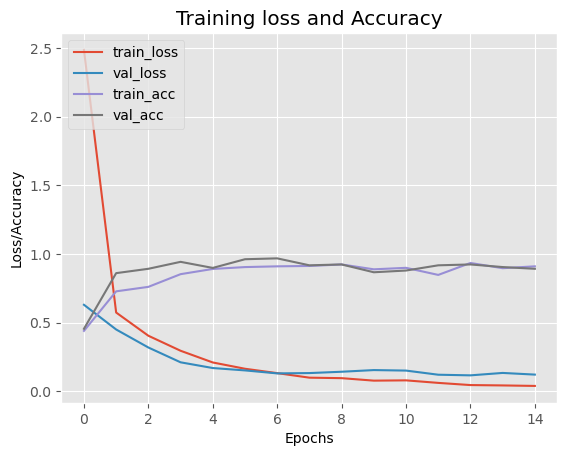

In [9]:
plt.style.use("ggplot")
plt.figure()

plt.plot(score.history["loss"],label ="train_loss")
plt.plot(score.history["val_loss"],label="val_loss")
plt.plot(score.history["accuracy"],label="train_acc")
plt.plot(score.history["val_accuracy"],label="val_acc")
plt.title("Training loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "upper left")
plt.show()

In [56]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 2s 386ms/step - loss: 0.1221 - accuracy: 0.8924


[0.12208711355924606, 0.892405092716217]

In [62]:
model.save_weights("modelf.h5")

In [57]:
from sklearn import metrics
preds = np.round(model.predict(X_test),0)
labels = ['overripe','ripe','unripe']
classification_metrics = metrics.classification_report(y_test,preds,target_names=labels)

5/5 [==============================] - 2s 400ms/step


In [58]:
print(classification_metrics)

              precision    recall  f1-score   support

    overripe       1.00      1.00      1.00        70
        ripe       0.96      1.00      0.98        87
      unripe       0.76      0.74      0.75        42

   micro avg       0.93      0.94      0.94       199
   macro avg       0.90      0.91      0.91       199
weighted avg       0.93      0.94      0.94       199
 samples avg       0.95      0.96      0.94       199



In [59]:
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[62  3  5]
 [ 0 82  2]
 [ 0  4  0]]


<Axes: >

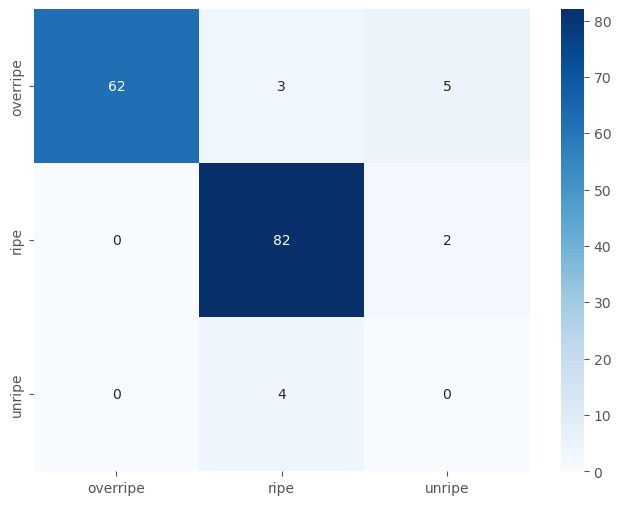

In [61]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels = labels, yticklabels = labels)

1/1 [==============================] - 0s 37ms/step
ripe (0.999)
unripe (0.00202)
overripe (2.17e-07)


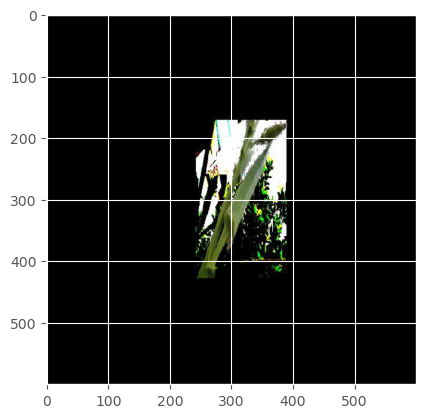

In [70]:
img = image.load_img('train/18_edited_png_jpg.rf.4d31c13415b9ae9b33a3b0628521ec8f.jpg',target_size=(600,600,3))
img = image.img_to_array(img)
img = img/255


classes = np.array(train.columns[:])
proba = model.predict(img.reshape(1,600,600,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

1/1 [==============================] - 0s 38ms/step
ripe (0.991)
unripe (0.991)
overripe (0.000119)


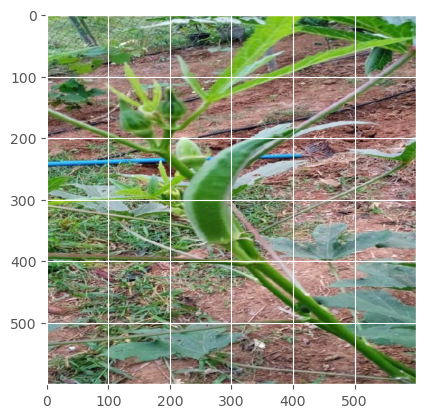

In [71]:
img = image.load_img('train/23_original_jpeg_jpg.rf.cb550d8180b5a01bd989e3a9f9b6fa7e.jpg',target_size=(600,600,3))
img = image.img_to_array(img)
img = img/255


classes = np.array(train.columns[:])
proba = model.predict(img.reshape(1,600,600,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

1/1 [==============================] - 0s 38ms/step
ripe (1.0)
unripe (0.00103)
overripe (3.78e-08)


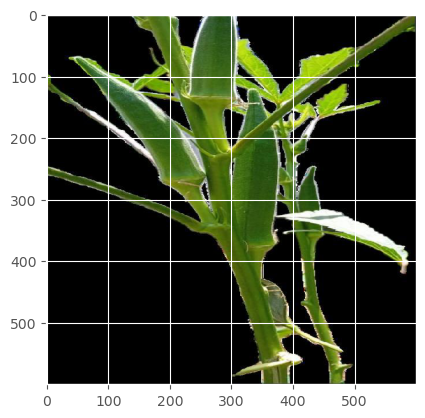

In [72]:
img = image.load_img('train/9_edited_png_jpg.rf.748d085cd85af392097bd8ef59b45833.jpg',target_size=(600,600,3))
img = image.img_to_array(img)
img = img/255


classes = np.array(train.columns[:])
proba = model.predict(img.reshape(1,600,600,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

1/1 [==============================] - 0s 38ms/step
ripe (0.986)
unripe (0.00717)
overripe (0.00148)


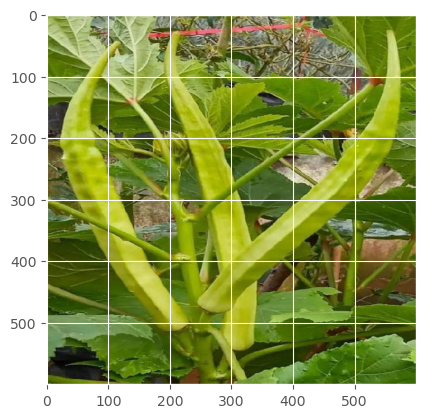

In [73]:
img = image.load_img('train/81d2e70269ab00321337ade4a5c4d6ab_jpg.rf.1e0d60c8c9890ba2e6c1ca11f2b59bf7.jpg',target_size=(600,600,3))
img = image.img_to_array(img)
img = img/255


classes = np.array(train.columns[:])
proba = model.predict(img.reshape(1,600,600,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

1/1 [==============================] - 0s 41ms/step
ripe (0.972)
unripe (0.036)
overripe (0.0107)


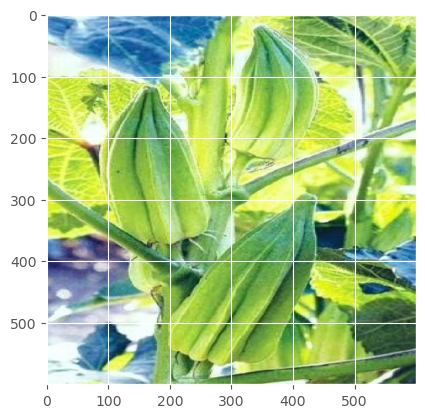

In [74]:
img = image.load_img('train/df7608737e01a834c109f87f1ef233ce_jpg.rf.e005d5a88ad5a9673913190dc32394a8.jpg',target_size=(600,600,3))
img = image.img_to_array(img)
img = img/255


classes = np.array(train.columns[:])
proba = model.predict(img.reshape(1,600,600,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)